# Import libraries

In [2]:
from sklearn.tree import DecisionTreeClassifier 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score

# Load the data

In [3]:
target=pd.read_csv('training_set_labels.csv').sort_values(by='id')
features=pd.read_csv('Training_set_values.csv').sort_values(by='id')
df=target.merge(features,on='id')

In [43]:
df.shape

(59400, 41)

# Data Cleaning 

In [4]:
# check missing values
missing=pd.DataFrame(df.isnull().sum()).reset_index()
missing.columns=['feature','missing_values']
missing.head()

,feature,missing_values
0,id,0
1,status_group,0
2,amount_tsh,0
3,date_recorded,0
4,funder,3635


In [5]:
# delete the columns which contains more than 20% missing values
col_names=[]
for i in range(len(missing)):
    if missing['missing_values'][i]/len(df)<=0.2:
        col_names.append(missing['feature'][i])
print(col_names)

['id', 'status_group', 'amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer', 'longitude', 'latitude', 'wpt_name', 'num_private', 'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward', 'population', 'public_meeting', 'recorded_by', 'scheme_management', 'permit', 'construction_year', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']


In [6]:
df1=df[col_names].dropna(axis=0)

# Feature Engineering

In [7]:
df1['target']=df1['status_group'].map({'functional':1,
                                        'functional needs repair':2,
                                        'non functional':0})

In [8]:
from sklearn import  preprocessing

In [9]:
# create a function to transform the data 
def encode(data):
    le = preprocessing.LabelEncoder()
    le.fit(data)
    return le.transform(data)

In [10]:
df1['date_recorded']=df1['date_recorded'].apply(lambda x : x[:4] ) # choose year only

In [11]:
for i in df1.columns:
    df1[i]=encode(df1[i])    # transform the data

In [13]:
df2=df1.drop(columns=['id','status_group']) # frop ID and status_group

In [45]:
df2.shape

(48288, 39)

In [39]:
# crop some columns if some columns contian other columns 
# such as quantity_group and quantitly so I decide drop quantity group and keep quantity
# because quantity is more variouse.
drop_list=['target','num_private','wpt_name','recorded_by','quantity_group','construction_year','management_group','subvillage']
inputs=df2.drop(columns=drop_list)
target=df2.target               

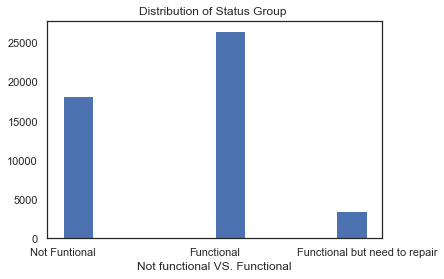

In [40]:
plt.hist(target)
plt.title("Distribution of Status Group ")
plt.xlabel("Not functional VS. Functional")
plt.xticks([0,1,2],['Not Funtional','Functional','Functional but need to repair'])
plt.show() 

# Feature Selection

In [41]:
x_train, x_test, y_train, y_test = train_test_split(inputs,target, random_state=10,test_size=0.2)
x_train=pd.DataFrame(data=x_train, columns=x_train.columns)
x_test=pd.DataFrame(data=x_test, columns=x_train.columns)

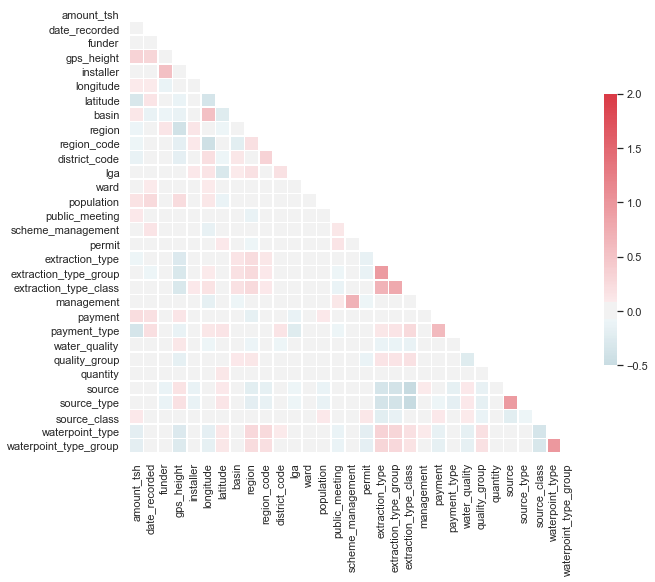

In [42]:

sns.set(style="white")


# Compute the correlation matrix
corr = x_train.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=2, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink":.5})
plt.show()

In [17]:
len(x_test.columns)


32

In [44]:
len(inputs.columns)

31

In [18]:
from sklearn.utils import resample
# concatenate our training data back together
training  = pd.DataFrame()
training[list(x_train.columns)]=x_train
training['target']=y_train
# separate minority and majority classes
not_func= training[training.target==0]
func= training[training.target==1]
func_rep= training[training.target==2]

not_func_upsampled = resample(not_func,
                          replace=True, # sample with replacement
                          n_samples=len(func), # match number in majority class
                          random_state=23) # reproducible results

# upsample minority
func_rep_count_upsampled = resample(func_rep,
                          replace=True, # sample with replacement
                          n_samples=len(func), # match number in majority class
                          random_state=23) # reproducible results

upsampled= pd.concat([func, not_func_upsampled,func_rep_count_upsampled])
upsampled.target.value_counts()

y_train = upsampled.target
x_train = upsampled.drop('target', axis=1)

# data standardization

In [19]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()  
scaler.fit(x_train)

X_train = scaler.transform(x_train)  
X_test = scaler.transform(x_test)  

# GridSearch

In [20]:
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

In [25]:
# given prameters different values
random_grid={'max_depth':list(range(1,30,2)),'criterion':['gini','entropy']}

In [26]:
# our decision tree model 
dtc=DecisionTreeClassifier(random_state=46)

In [27]:
# fit grid search  
GS=GridSearchCV(dtc,random_grid,cv=10)
GS.fit(X_train,y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=46,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                    

In [28]:
# obtian the best criterion= 'gini' and max_depth =29 
GS.best_params_

{'criterion': 'gini', 'max_depth': 29}

In [29]:
# obtian the best score 
GS.best_score_

0.9064595336945495

# Decision Tree Model

In [30]:
# using the best parameters that I obtianed from grid search and using same random_state
dtc_final=DecisionTreeClassifier(max_depth= 29,
                               criterion='gini',
                              random_state=46)

In [31]:
dtc_final.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=29, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=46, splitter='best')

In [32]:
print('Accuracy score of train data :{}'.format(dtc_final.score(X_train,y_train)))
print('Accuracy score of test data:{}'.format(dtc_final.score(X_test,y_test)))

Accuracy score of train data :0.9879444313633153
Accuracy score of test data:0.7494305239179955


 `A macro-average will compute the metric independently for each class and then take the average (hence treating all classes equally), whereas a micro-average will aggregate the contributions of all classes to compute the average metric.`

In [34]:
# obtian train data f1_Score
dt_pre_train=dtc_final.predict(X_train)
print('Train data f1_Score:{}'.format(f1_score(y_train,dt_pre_train,average='macro')))
# Obtain Test data f1_Score
dt_smote_pred=dtc_final.predict(X_test)
print('Test data f1_Score:{}'.format(f1_score(y_test, dt_smote_pred,average='macro')))

Train data f1_Score:0.9879444812155255
Test data f1_Score:0.6417297171175534
